# Correcting Undercatched solid precipitation

--- 
**Date** : 30/04/2025 \
**Data used** : Lautaret's data : *https://gricad-gitlab.univ-grenoble-alpes.fr/lautaret/fluxalp/-/tree/master/data_clean_hydro_year?ref_type=heads* \
**Biblio used** : Kochendorfer, J., et. al. : *Analysis of single-Alter-shielded and unshielded measurements of mixed and solid precipitation from WMO-SPICE*, Hydrol. Earth Syst. Sci., 21, 3525–3542, https://doi.org/10.5194/hess-21-3525-2017, 2017. \
**Practical steps** :
1. Read Flux'Alp data
2. Locate snow precipitation (snow-rain limit = 1°C)
3. Calcul catch efficiency coefficient of the gauge
4. Correct precipitation amount
5. Write data in a file

## Import

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../scripts/")
import file_functions as fct

## Read data 2018-2024

In [2]:
file_dir = '~/shared-storage/fluxalp/data_clean_hydro_year/'

df_2018_2019 = fct.read_csv_lautaret(file_dir,'2018-2019')
df_2019_2020 = fct.read_csv_lautaret(file_dir,'2019-2020')
df_2020_2021 = fct.read_csv_lautaret(file_dir,'2020-2021')
df_2021_2022 = fct.read_csv_lautaret(file_dir,'2021-2022')
df_2022_2023 = fct.read_csv_lautaret(file_dir,'2022-2023')
df_2023_2024 = fct.read_csv_lautaret(file_dir,'2023-2024')

df_raw = pd.concat([df_2018_2019, df_2019_2020, df_2020_2021, df_2021_2022, df_2022_2023, df_2023_2024])
variables_util = ['short_up_Avg', 'Albedo_Avg', 'long_up_cor_Avg', 'Quantity_raw', 'AirTC_Avg', 'WindSpeed_Avg', 'Patm_Avg',  'HRair_Avg', 'Snow_Depth']
df = df_raw.copy().loc[:,variables_util]
df.head()

,short_up_Avg,Albedo_Avg,long_up_cor_Avg,Quantity_raw,AirTC_Avg,WindSpeed_Avg,Patm_Avg,HRair_Avg,Snow_Depth
datetime,,,,,,,,,
2018-10-17 00:00:00+00:00,-1.439137,NaN,308.8568,NaN,5.4218,2.132,798.9,88.14690,NaN
2018-10-17 00:30:00+00:00,-2.261506,NaN,286.7975,0.0,5.4869,2.888,798.8,86.68269,NaN
2018-10-17 01:00:00+00:00,-2.656018,NaN,280.6507,0.0,5.2648,3.013,798.7,86.10909,NaN
2018-10-17 01:30:00+00:00,-2.617169,NaN,279.7586,0.0,5.2203,1.799,798.6,87.65050,NaN
2018-10-17 02:00:00+00:00,-3.045069,NaN,264.3238,0.0,4.7687,2.194,798.4,89.26050,NaN


## Precipitation under T = 1°C is considered as solid precipitation

In [3]:
rain_snow_limit = 1
precip_snow = df.loc[df['AirTC_Avg']<=rain_snow_limit, 'Quantity_raw']

## Calcul catch efficiency coefficient

In [4]:
df.loc['2018' : '2021-05', 'catch_efficiency'] = fct.catch_efficiency_unshield(df.loc['2018' : '2021-05', 'AirTC_Avg'], df.loc['2018' : '2021-05', 'WindSpeed_Avg'])
df.loc['2021-06' : '2024', 'catch_efficiency'] = fct.catch_efficiency_single_alter(df.loc['2021-06' : '2024', 'AirTC_Avg'], df.loc['2021-06' : '2024', 'WindSpeed_Avg'])

## Correction of precipitation

In [5]:
precip_snow_corr = precip_snow + ( 1 - df.loc[precip_snow.index,'catch_efficiency']) * precip_snow

df.loc[precip_snow_corr.index, 'Quantity_raw'] = precip_snow_corr

## Comparison with data not corrected

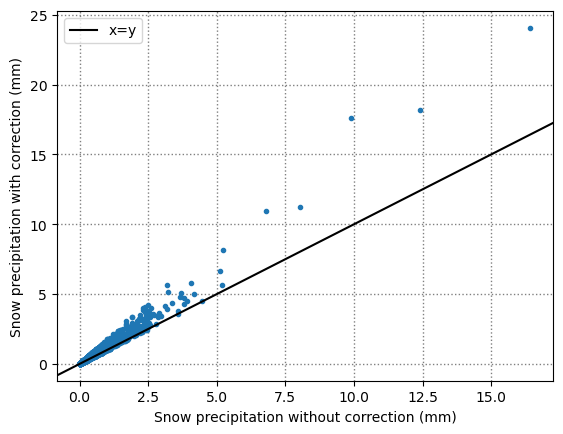

In [11]:
plt.plot(precip_snow, precip_snow_corr, '.')
plt.axline([0,0], slope = 1, color = 'black', label = 'x=y')
plt.xlabel('Snow precipitation without correction (mm)')
plt.ylabel('Snow precipitation with correction (mm)')
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.legend()

In [7]:
hydro_year = ['2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024']

stats = pd.DataFrame(index = hydro_year)

for i in hydro_year :
    stats.loc[i,'cumul precip snow'] = precip_snow.loc[i[:4]+'-10-17' : i[5:]+'-10-16'].sum()
    stats.loc[i,'cumul precip snow corrected'] = round(precip_snow_corr.loc[i[:4]+'-10-17' : i[5:]+'-10-16'].sum(),2)
    stats.loc[i,'annual mean precip snow'] = round(precip_snow.loc[i[:4]+'-10-17' : i[5:]+'-10-16'].mean(),3)
    stats.loc[i,'annual mean precip snow corrected'] = round(precip_snow_corr.loc[i[:4]+'-10-17' : i[5:]+'-10-16'].mean(),3)

In [8]:
stats

,cumul precip snow,cumul precip snow corrected,annual mean precip snow,annual mean precip snow corrected
2018-2019,346.11,480.02,0.056,0.077
2019-2020,381.09,558.19,0.064,0.094
2020-2021,309.40,420.93,0.050,0.068
2021-2022,271.98,347.01,0.050,0.064
2022-2023,368.21,459.10,0.064,0.080
2023-2024,580.65,730.27,0.100,0.126


## Writing data corrected in a file

In [9]:
output_file = df_raw.copy()
output_file['Quantity_raw'] = df['Quantity_raw']
output_file.to_csv('resulting_data/1-Fluxalp_corrected-snow-precip_2018_2024.dat')